# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

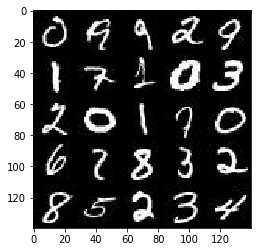

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

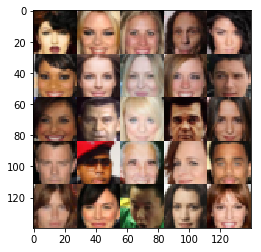

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse = reuse):
        #alpha is the param for leaky relu
        alpha=0.2
        
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(layer1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d(layer2, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        flat = tf.contrib.layers.flatten(layer3)
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse = reuse):
        
        layer1 = tf.layers.dense(z,  7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        
        layer1 = tf.layers.batch_normalization(layer1, training = is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides = 2, padding = 'same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same')
        
        output = tf.tanh(logits) 
    return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)  
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images_h in get_batches(batch_size):
                
                steps += 1
                batch_images = batch_images_h*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})


                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                #    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 2.7179... Generator Loss: 0.2019
Epoch 1/2... Discriminator Loss: 2.8561... Generator Loss: 0.1905
Epoch 1/2... Discriminator Loss: 2.5434... Generator Loss: 0.1674
Epoch 1/2... Discriminator Loss: 2.2548... Generator Loss: 0.3327
Epoch 1/2... Discriminator Loss: 1.8823... Generator Loss: 0.5118
Epoch 1/2... Discriminator Loss: 2.0773... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.9946... Generator Loss: 0.4339
Epoch 1/2... Discriminator Loss: 1.9799... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.4330


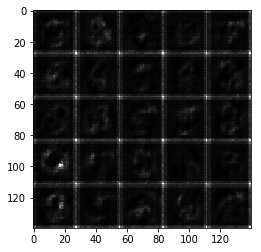

Epoch 1/2... Discriminator Loss: 1.7207... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.9477... Generator Loss: 0.2823
Epoch 1/2... Discriminator Loss: 1.7741... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.5676... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 1.6802... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.6529... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.5051
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.4991
Epoch 1/2... Discriminator Loss: 1.6034... Generator Loss: 0.3910
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.5826


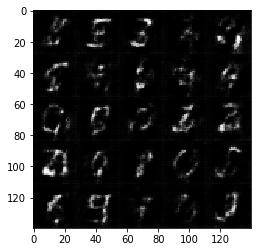

Epoch 1/2... Discriminator Loss: 1.6463... Generator Loss: 1.4673
Epoch 1/2... Discriminator Loss: 1.5246... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.9512
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 0.5021
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.5159
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.5444
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.6612... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 0.4916


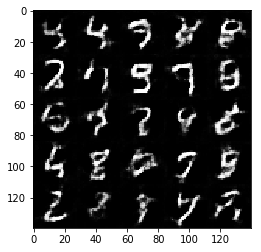

Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.5181... Generator Loss: 0.9778
Epoch 1/2... Discriminator Loss: 1.5991... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.8505... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.5653... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 1.6559... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.6052


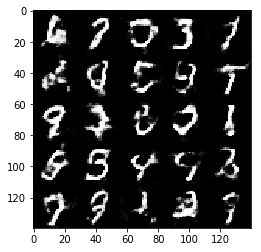

Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.6051
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.5082... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.7141... Generator Loss: 0.3509
Epoch 1/2... Discriminator Loss: 1.6050... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 1.6231... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.6182
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.6938


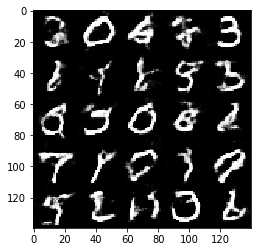

Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.5330
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.8919
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 1.4394... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.5132... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 0.5266


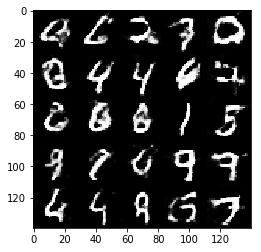

Epoch 1/2... Discriminator Loss: 1.4764... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.6646... Generator Loss: 0.3900
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.6741
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.5642... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.8085


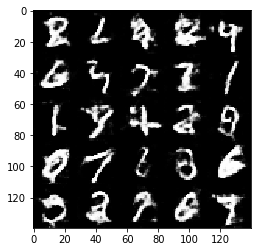

Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.5896... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.5154... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.4597
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 1.6021... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.6179


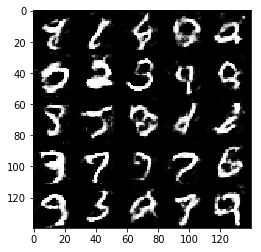

Epoch 1/2... Discriminator Loss: 1.4450... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 1.5358... Generator Loss: 1.3188
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 0.3884
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.6465... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.8546


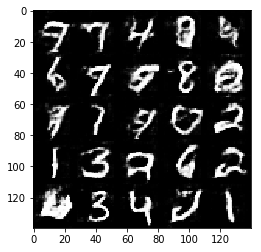

Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 1.4341... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.7454
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.6906... Generator Loss: 0.3941


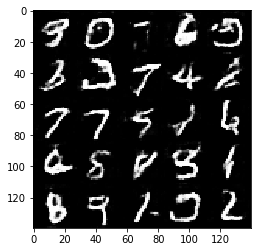

Epoch 2/2... Discriminator Loss: 1.5503... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.9919
Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.5493... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.3669


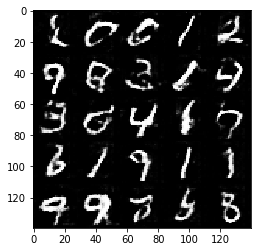

Epoch 2/2... Discriminator Loss: 1.5802... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.5581... Generator Loss: 0.9284
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.5838... Generator Loss: 0.4458
Epoch 2/2... Discriminator Loss: 1.5239... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 1.4984... Generator Loss: 0.6023
Epoch 2/2... Discriminator Loss: 1.6077... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.5638... Generator Loss: 0.5357
Epoch 2/2... Discriminator Loss: 1.6686... Generator Loss: 0.3774
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.5734


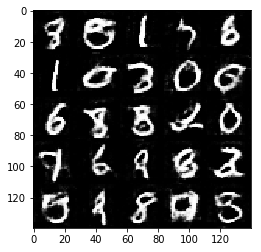

Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 1.5212... Generator Loss: 0.5849
Epoch 2/2... Discriminator Loss: 1.6022... Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.5081... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 1.5978... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 1.5168... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 0.5535


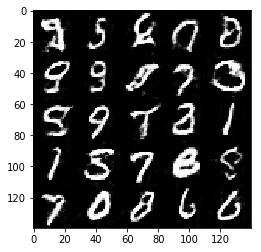

Epoch 2/2... Discriminator Loss: 1.5322... Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 1.4731... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.5584... Generator Loss: 0.4569
Epoch 2/2... Discriminator Loss: 1.6139... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 1.4911... Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 1.5699... Generator Loss: 0.4655
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.5621... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 1.0949


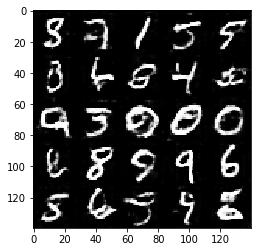

Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 0.5433
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.5405... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 1.5259... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 1.6191... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.7663


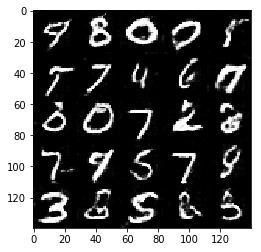

Epoch 2/2... Discriminator Loss: 1.6776... Generator Loss: 0.3827
Epoch 2/2... Discriminator Loss: 1.5136... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.7303... Generator Loss: 0.3630
Epoch 2/2... Discriminator Loss: 1.5547... Generator Loss: 0.8172
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.9662
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.9280


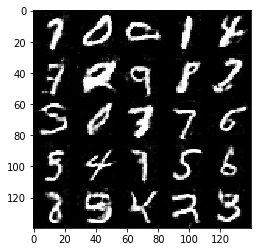

Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.6063
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.5896... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.5078... Generator Loss: 0.6717


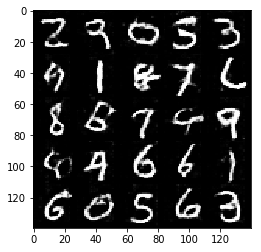

Epoch 2/2... Discriminator Loss: 1.5690... Generator Loss: 0.4173
Epoch 2/2... Discriminator Loss: 1.6160... Generator Loss: 0.4403
Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.4248... Generator Loss: 1.1210
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.9987
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 1.4995... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 1.0504


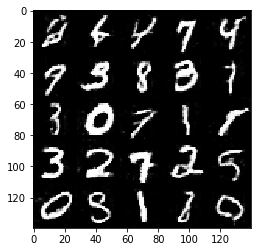

Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.5885... Generator Loss: 0.3909
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.4741... Generator Loss: 0.5412


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.4160... Generator Loss: 0.0134
Epoch 1/1... Discriminator Loss: 3.3160... Generator Loss: 0.1093
Epoch 1/1... Discriminator Loss: 2.9958... Generator Loss: 0.1500
Epoch 1/1... Discriminator Loss: 3.7204... Generator Loss: 0.0915
Epoch 1/1... Discriminator Loss: 2.5030... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 2.5603... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 2.1157... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 2.4331... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 2.3060... Generator Loss: 0.3018


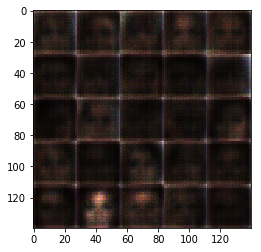

Epoch 1/1... Discriminator Loss: 2.3429... Generator Loss: 0.3150
Epoch 1/1... Discriminator Loss: 2.3368... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.9144... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 1.8209... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.9506... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 2.0022... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.8013... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.7176... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 0.6299


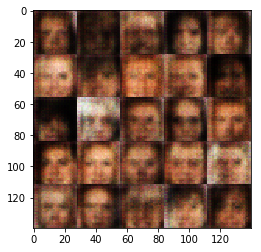

Epoch 1/1... Discriminator Loss: 1.9610... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.8133... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.7315... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.5811


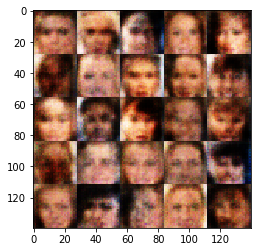

Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.8855


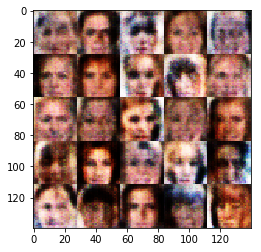

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.5784


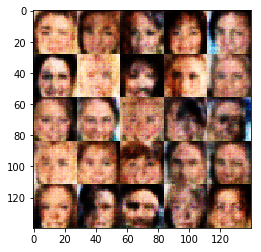

Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6651


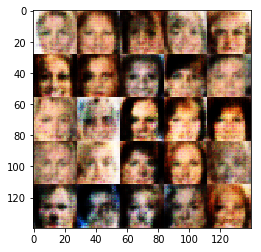

Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.7617... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.8333


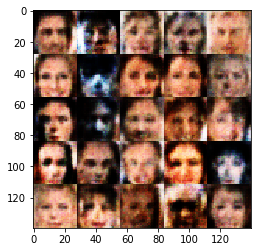

Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7687


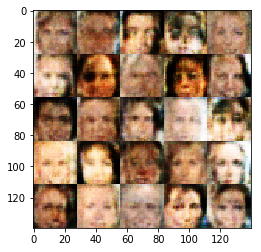

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.7196


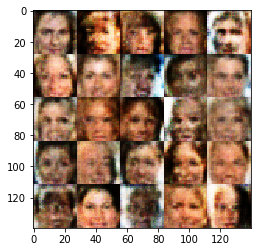

Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7537


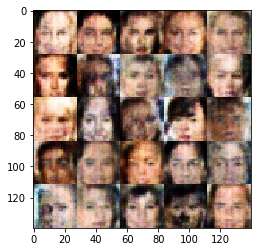

Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6906


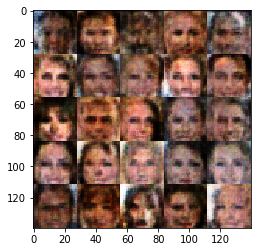

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7442


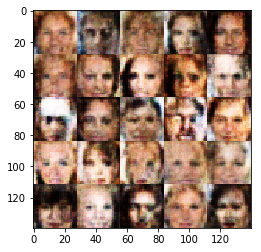

Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7347


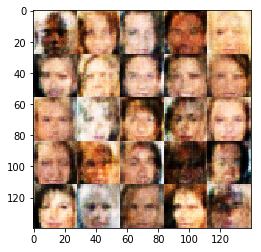

Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.7543


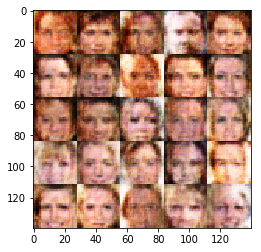

Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7748


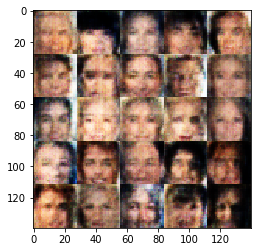

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7404


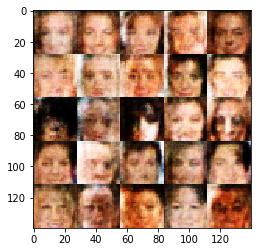

Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7213


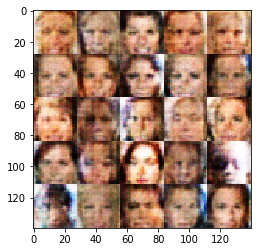

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7330


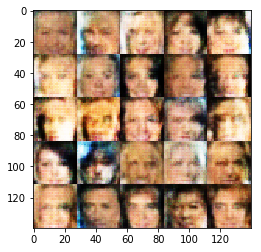

Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7666


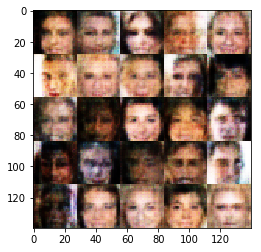

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.7309


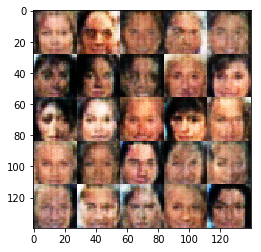

Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7829


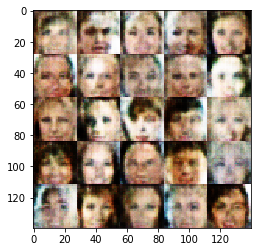

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7468


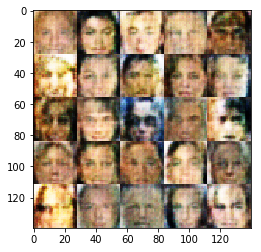

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8431


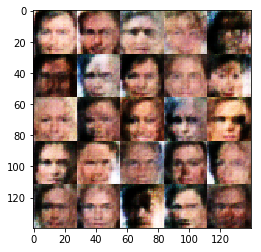

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7638


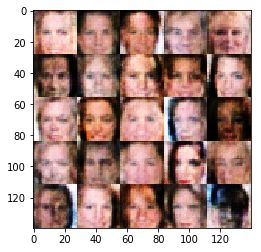

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.8920


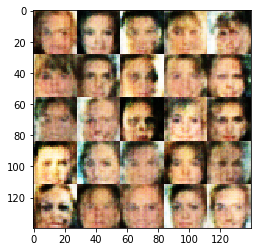

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7716


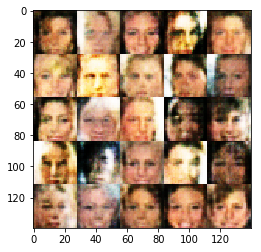

Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7695


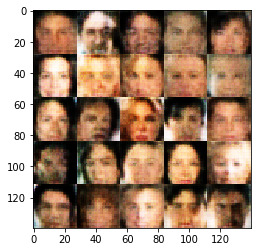

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7148


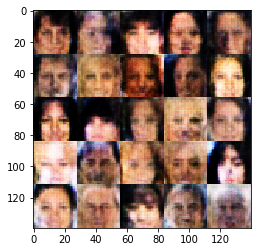

Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7773


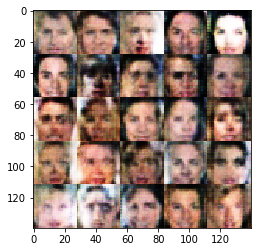

Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7552


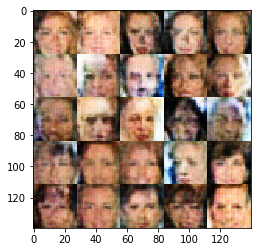

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7290


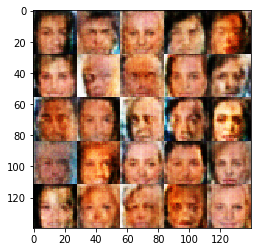

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7402


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.